In [1]:
# %matplotlib widget
# %matplotlib tk
import godot

import numpy as np
from godot.core import tempo, util
import matplotlib.pyplot as plt
import pickle


# optionally avoid verbose logging messages
import godot.core.util as util
util.suppressLogger()

import os
os.makedirs('./output/',exist_ok = True)

# create the universe
uni_config = godot.cosmos.util.load_yaml('universe2.yml')
uni = godot.cosmos.Universe(uni_config)

In [2]:
year = 2027
filename = './output/year_sim/one_year_' + str(year) + '.pickle'
with open(filename, 'rb') as f:
    res = pickle.load(f)

In [3]:
# with open("/home/es820/Documents/GODOTWork/output/elevations/CB11_elevations.pickle", 'rb') as f:
#     elevold = pickle.load(f)

In [4]:
print('loaded!')
e = res.elv('CB11')
print(type(e.values))

loaded!
<class 'numpy.ndarray'>


In [5]:
import mani_rain
from mani.StateEvaluator import SEEnum
condition = res.above_elev('CB11', 10.0) & res.has([SEEnum.CLEAR_MOON_CB])
elevations = res.df.loc[condition]['CB11']

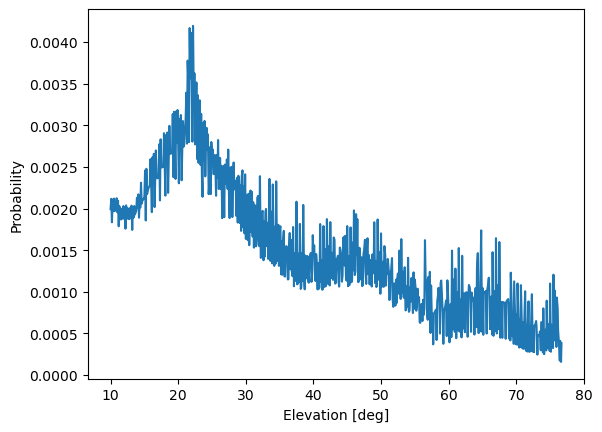

In [6]:
with open('./output/elevations/NN11_elevations.pickle', 'wb') as f:
    pickle.dump(elevations, f, protocol=pickle.HIGHEST_PROTOCOL)
nn = mani_rain.new_norcia
nn.gen_el_dist(file='./output/elevations/NN11_elevations.pickle')

plt.figure()
plt.plot(*nn.el_distribution)
plt.xlabel("Elevation [deg]")
plt.ylabel("Probability")
plt.show()

link = mani_rain.link_budget_itu(nn, 100e6)
# dist = 384400e3
# rain_rate = 4 #mmhr⁻¹
# rain_rates = np.full(len(elevations), rain_rate)
# snr_list = []
# for idx, el in enumerate(elevations):
#     snr_list.append(link.snr_at_t(dist, el, rain_rates[idx]))
# plt.figure()
# plt.plot(elevations, snr_list)
# plt.grid()
# plt.xlabel("Elevation [Deg]")
# plt.ylabel("SNR [dB]")
# plt.show()

In [7]:
from tqdm import tqdm
n_rains = int(np.ceil(len(res.df) / 60) // 1e3) 
print(n_rains) 
rain_p = np.random.uniform(0,1,n_rains)
snrs = np.empty_like(rain_p)
rates = np.empty_like(rain_p)

link = mani_rain.link_budget_itu(nn, 100e6)

dist = 384400e3
for i, p in enumerate(tqdm(rain_p)):
    link.rain_model.p = p
    snrs[i] = link.snr_at_t(dist, 45)
    rates[i] = link.dvb_s2_cap(snrs[i])

plt.plot(rates)

525


  5%|▍         | 24/525 [00:01<00:33, 14.96it/s]


AttributeError: 'NoneType' object has no attribute 'spectral_eff'

In [ ]:
link